In [1]:
import matplotlib as mpl
import numpy as np

import xarray as xr

In [2]:
xr.set_options(display_style="html")

# Load data

In [3]:
ds = xr.tutorial.open_dataset("air_temperature.nc").rename({"air": "Tair"})

# we will add a gradient field with appropriate attributes
ds["dTdx"] = ds.Tair.differentiate("lon") / 110e3 / np.cos(ds.lat * np.pi / 180)
ds["dTdy"] = ds.Tair.differentiate("lat") / 105e3
ds.dTdx.attrs = {"long_name": "$∂T/∂x$", "units": "°C/m"}
ds.dTdy.attrs = {"long_name": "$∂T/∂y$", "units": "°C/m"}

ds

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    Tair     (time, lat, lon) float32 241.2 242.5 243.5 ... 296.49 296.19 295.69
    dTdx     (time, lat, lon) float32 1.826483e-05 ... -1.8823205e-06
    dTdy     (time, lat, lon) float32 -9.904727e-06 ... -1.9047619e-06
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

This dataset has three variables, ``Tair`` is air temperature and ``dTdx`` and ``dTdy`` are horizontal gradients of this temperature field.

# Basic plotting

DataArray objects have a ``plot`` method that uses ``matplotlib``. By default ``.plot()`` makes
1. a line plot for 1-D arrays
2. a ``pcolormesh`` plot for 2-D arrays
3. a histogram for everything else

(array([   2182.,   60537.,  195026.,  233763.,  315219.,  635948.,
         778807., 1192236.,  453381.,    1901.]),
 array([221.     , 230.64   , 240.28   , 249.92   , 259.56   , 269.2    ,
        278.84   , 288.47998, 298.12   , 307.76   , 317.4    ],
       dtype=float32),
 <a list of 10 Patch objects>)

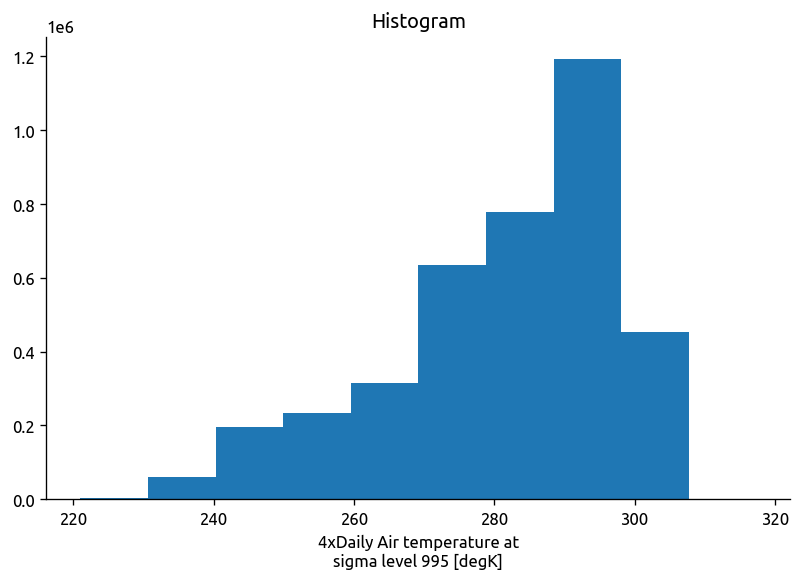

In [4]:
ds.Tair.plot()

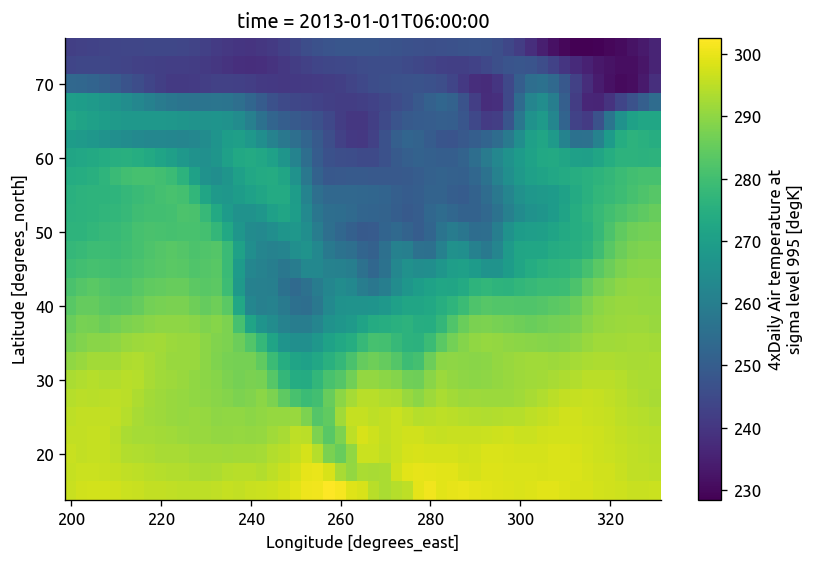

In [5]:
ds.Tair.isel(time=1).plot()

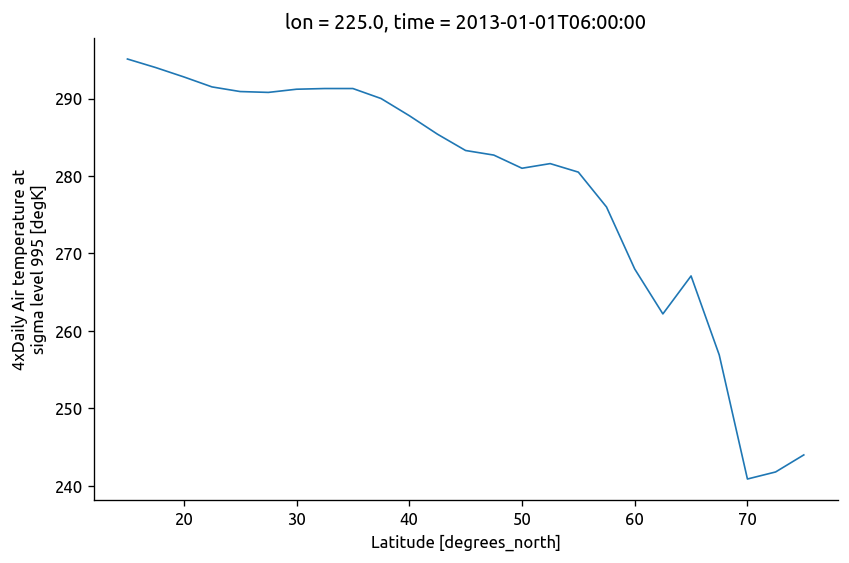

In [6]:
ds.Tair.isel(time=1, lon=10).plot()

# Customization

# Faceting

Faceting is the art of presenting "small multiples" of the data. We will use monthly means to illustrate

In [7]:
# This is a bad estimate that does not take into account the fact that months have different number of days.
monthly_means = ds.groupby("time.month").mean()
monthly_means

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, month: 12)
Coordinates:
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Tair     (month, lat, lon) float32 246.34987 246.38608 ... 297.53763
    dTdx     (month, lat, lon) float32 5.081737e-07 ... -1.042875e-07
    dTdy     (month, lat, lon) float32 -9.553304e-06 ... -3.871585e-06
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

The simplest way to facet is to specify the ``row`` or ``col`` kwargs which are expected to be a dimension name. Here we use ``month`` so that each panel or "facet" of the plot presents the mean temperature field in a given month. Since a 12 column plot would be too small to interpret, we can "wrap" the facets into multiple rows using ``col_wrap``

In [ ]:
fg = monthly_means.Tair.plot(
    col="month", col_wrap=4,  # TODO: try commenting this line out
)

All the usual customizations are possible

In [ ]:
fg = monthly_means.Tair.plot(
    col="month",
    col_wrap=4,
    robust=True,
    cmap=mpl.cm.RdYlBu_r,
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
)

#### Exercise

The returned FacetGrid object ``fg`` has many useful properties and methods e.g. 
1. ``fg.fig`` provides a handle to the figure
2. ``fg.axes`` is a numpy object array with handles to each individual axes
3. ``fg.set_xlabels`` and ``fg.set_ylabels`` can be used to change axes labels.

Use these properties to set a title for the figure.

## Tip: Use faceting to plot multiple DataArrays

Faceting can be used to plot multiple DataArrays in a Dataset. The trick is to use ``to_array()`` to convert a Dataset to a DataArray and thne facet that. 

This trick only works when it is sensible to use the same colormap and color scale for all DataArrays like with ``dTdx`` and ``dTdy``

In [ ]:
gradients = monthly_means[["dTdx", "dTdy"]].to_array("gradient")
gradients

In [ ]:
fg = gradients.isel(month=slice(None, None, 3)).plot.contourf(
    levels=13,
    col="month",
    row="gradient",
    robust=True,
    cmap=mpl.cm.coolwarm,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "label": "Gradient [°C/m]",
    },
)

## Modifying all facets of a plot

In [ ]:
fg = gradients.isel(month=slice(None, None, 3)).plot.contourf(
    levels=13,
    col="month",
    row="gradient",
    robust=True,
    cmap=mpl.cm.coolwarm,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "label": "Gradient [°C/m]",
    },
)

fg.map_dataarray(
    xr.plot.contour, x="lon", y="lat", colors="k", levels=13, add_colorbar=False
)
fg.map(lambda: plt.plot(250, 40, markersize=20, marker=".", color="k"))

# Interactive bokeh plots using hvplot

In [ ]:
import hvplot.xarray

### ``hvplot`` makes the same default choices as xarray 

In [ ]:
ds.Tair.hvplot()

In [ ]:
ds.Tair.isel(time=1).hvplot()

In [ ]:
ds.Tair.isel(time=1, lon=1).hvplot()

## Interactivity 

But ``hvplot`` shines when interactivity is used. Here we can give it *all* the data and ask it to create a nice slider to control the time slice, and interactively visualize our data

In [ ]:
ds.Tair.hvplot(groupby="time")

Animations are easy

In [ ]:
ds.Tair.hvplot(groupby="time", widget_type="scrubber", widget_location="bottom")

# Geography

## matplotlib and cartopy

In [ ]:
import cartopy.crs as ccrs

f, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Orthographic(-90, 30)))

ds.Tair.isel(time=1).plot(
    ax=ax, robust=True, transform=ccrs.PlateCarree(),
)
ax.coastlines()

## hvplot

In [ ]:
ds.Tair.hvplot(
    groupby="time",
    widget_type="scrubber",
    widget_location="bottom",
    projection=ccrs.Orthographic(-90, 30),
    coastline=True,
)